---

# Finetuning Moondream

- Basic code: a notebook offered by Moondream showing a simple fine-tuning on a image data set; (sadly, was deleted, but replaced with .py files: https://github.com/vikhyat/moondream/pull/227/files/ddcc76b2620ea4f604780114e4bd906143c377b5#diff-057c55547ef25e32a2b920783c3d8d9cc3e651946bce9e9c6ba4653f18c2f1a9)

- Note: GPU required, we used the A100 provided with Google Colab Pro

---

### Installs and packages

In [ ]:
!pip install torch transformers timm einops bitsandbytes accelerate flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 51.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 33.8 MB/s eta 0:00:00
  

In [ ]:
!pip install pyvips
!apt-get update
!apt-get install libvips libvips-dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyvips: filename=pyvips-2.2.3-py2.py3-none-any.whl size=54849 sha256=5bc5048c8d5d91ffbc37261eae4e99ff2934870fe6d864ce5e94ed2579d69f9c
  Stored in directory: /root/.cache/pip/wheels/fc/2c/3a/120103ac3f113407daed5416c5386cd13172c92f68ee9f7208
Successfully built pyvips
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repo

In [ ]:
import random
from moviepy.video.io.VideoFileClip import VideoFileClip
from PIL import Image
import torch
from torchvision import transforms
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import pickle

### Our collected dataset

#### Mount drive

We used Google Colab and loaded and saved files from/to Google Drive.

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load dataset

- Youtube video frames and thumbnails and video transcripts
- ground truth labels are SD prompts generated by Gemini

In [ ]:
# unzip the frames

from zipfile import ZipFile

with ZipFile("/content/drive/My Drive/frames/frames.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="/content/imgs/")

In [ ]:
# load dataset

file_path = '/content/drive/My Drive/dataset_moon_2.pkl'

with open(file_path, 'rb') as file:
  if file:
    data = pickle.load(file)

print(data.keys())

dict_keys(['image_img', 'image_text', 'qa'])


#### Embed n video frames into one input embedding for MD

In [ ]:
# only needed if embeddings.pt not given
# frames (from videos) to embedding

'''
def video_to_emb(frame_path, combine_type, inference_finetune, num_frames):

    # open frames
    #print(frame_path)
    frames = []
    n = 100 / num_frames
    for i in range(100):
      if i % n == 0:
        frame = Image.open(f"{frame_path}/{i}.jpeg")
        #frame = frame.resize((378, 378))
        frames.append(frame)

    # Frames in embeddings
    embeddings = []
    if inference_finetune == "inference":
      preprocess = transforms.Compose([
          transforms.Resize((2048, 2048)),
          transforms.Grayscale(), # seems grayscale is needed for inference, but not for training
          transforms.ToTensor()
      ])
    if inference_finetune == "finetune":
      preprocess = transforms.Compose([
          transforms.Resize((378, 378)),
          #transforms.Grayscale(), # seems grayscale is needed for inference, but not for training
          transforms.ToTensor()
      ])
    model = AutoModelForCausalLM.from_pretrained(
      "vikhyatk/moondream2",
      revision="2025-01-09",
      trust_remote_code=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    for frame in frames:
        #print("frame", frame.shape)
        # Fix input tensor shape
        input_tensor = preprocess(frame)
        #print("input tensor", input_tensor.shape)
        with torch.no_grad():
            embedding = model(input_tensor)
            #print("mode inp tens", model(input_tensor).shape)
            #print("embedding", embedding.shape)
            embeddings.append(embedding)

    # Mean of embeddings
    if combine_type == 'mul':
      embedding_frames = 1
      for emb in embeddings:
        embedding_frames = embedding_frames * emb
    if combine_type == 'add':
      embedding_frames = 0
      for emb in embeddings:
        embedding_frames = embedding_frames + emb
    if combine_type == 'mean':
        embedding_frames = torch.mean(torch.stack(embeddings), dim=0)

    return embedding_frames
'''

'\ndef video_to_emb(frame_path, combine_type, inference_finetune, num_frames):\n\n    # open frames\n    #print(frame_path)\n    frames = []\n    n = 100 / num_frames\n    for i in range(100):\n      if i % n == 0:\n        frame = Image.open(f"{frame_path}/{i}.jpeg")\n        #frame = frame.resize((378, 378))\n        frames.append(frame)\n\n    # Frames in embeddings\n    embeddings = []\n    if inference_finetune == "inference":\n      preprocess = transforms.Compose([\n          transforms.Resize((2048, 2048)),\n          transforms.Grayscale(), # seems grayscale is needed for inference, but not for training\n          transforms.ToTensor()\n      ])\n    if inference_finetune == "finetune":\n      preprocess = transforms.Compose([\n          transforms.Resize((378, 378)),\n          #transforms.Grayscale(), # seems grayscale is needed for inference, but not for training\n          transforms.ToTensor()\n      ])\n    model = AutoModelForCausalLM.from_pretrained(\n      "vikhyatk/m

In [ ]:
# only needed if embeddings.pt not given
# create embeddings for finetuning

'''
embeddings = []

i = 0
for img in data["image_img"]:
  if os.path.exists(f"imgs/frames/{img}"):
    #if i <= 1: # !!! remove later with frames
    embedded_frames = video_to_emb("imgs/frames/" + img, combine_type = 'mean', inference_finetune = "finetune", num_frames = 2)
    embeddings.append(embedded_frames)
    i += 1
    #else:
    #  break

data["image_emb"] = embeddings
'''

'\nembeddings = []\n\ni = 0\nfor img in data["image_img"]:\n  if os.path.exists(f"imgs/frames/{img}"):\n    #if i <= 1: # !!! remove later with frames\n    embedded_frames = video_to_emb("imgs/frames/" + img, combine_type = \'mean\', inference_finetune = "finetune", num_frames = 2)\n    embeddings.append(embedded_frames)\n    i += 1\n    #else:\n    #  break\n\ndata["image_emb"] = embeddings\n'

In [ ]:
# only needed if embeddings.pt not given
# save embeddings
#torch.save(embeddings, "/content/drive/My Drive/embeddings.pt")

In [ ]:
# embeddings with mean over 2 frames
data["image_emb"] = torch.load("/content/drive/My Drive/embeddings.pt")

  data["image_emb"] = torch.load("/content/drive/My Drive/embeddings.pt")



#### Shorten the video transcripts

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('stopwords')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
words = set(nltk.corpus.words.words())

processed_transcripts = []
for transcript in data['image_text']:
  word_tokens = word_tokenize(transcript)
  word_tokens = [w.lower() for w in word_tokens]
  word_tokens = [w for w in word_tokens if w not in stop_words]

  word_tokens = [w for w in word_tokens if w in words or not w.isalpha()]
  word_counts = Counter(word_tokens)
  most_common_words = [word for word, count in word_counts.most_common(15)]
  processed_transcripts.append(" ".join(most_common_words))

data['processed_image_text'] = processed_transcripts

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
data['processed_image_text'][1] # example of shortened transcript

"'s police care something say assassin employee family last united one monopoly valedictorian murder country"

#### Split in train and test data

In [ ]:
def get_item(data, idx):
  if os.path.exists(f"/content/imgs/frames/{data['image_img'][idx]}"):
    return {
        'image': f"/content/imgs/frames/{data['image_img'][idx]}/50.jpeg", #data['image_emb'][idx],
        'qa': [
            {
                'question': "Given this image and the video transcript, generate a prompt for Stable Diffusion. The response should only include the prompt. Here is the transcript: " + data['processed_image_text'][idx],
                'answer': data['qa']['answer'][idx],
            }
        ]
    }

get_item(data, 1)

{'image': '/content/imgs/frames/Yzt7KnWfwgs/50.jpeg',
 'qa': [{'question': "Given this image and the video transcript, generate a prompt for Stable Diffusion. The response should only include the prompt. Here is the transcript: 's police care something say assassin employee family last united one monopoly valedictorian murder country",
   'answer': " The image shows a young man standing on a grassy hillside, smiling at the camera. He is shirtless and wearing a black backpack. The hillside is covered in lush green vegetation, including ferns and other plants. The man's gaze is directed towards the camera, creating a sense of connection with the viewer. The image is taken from a slightly elevated angle, providing a view of the man and the surrounding landscape."}]}

In [ ]:
# split our own data in train and test set (80 | 20)

train_data = [get_item(data, i) for i in range(int(len(data['image_img']) * 0.8)) if get_item(data, i) is not None]
test_data = [get_item(data, i) for i in range(int(len(data['image_img']) * 0.8), int(len(data['image_img']))) if get_item(data, i) is not None]
len(train_data)

(564, 0)

Now let's take a look at a sample image from the training set and compare the ground-truth answers
with moondream predictions.

### Load Moondream model

In [ ]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float32 # CPU doesn't support float16
MD_REVISION = "2024-07-23"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision=MD_REVISION,
    trust_remote_code=True,
    attn_implementation=None if DEVICE == "cuda" else None,
    torch_dtype=DTYPE,
    device_map={"": DEVICE})

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/319 [00:00<?, ?B/s]

configuration_moondream.py:   0%|          | 0.00/3.34k [00:00<?, ?B/s]

moondream.py:   0%|          | 0.00/5.38k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

vision_encoder.py:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.73G [00:00<?, ?B/s]

PhiForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
print(train_data[0])

{'image': '/content/imgs/frames/Yzt7KnWfwgs/50.jpeg', 'qa': [{'question': "Given this image and the video transcript, generate a prompt for Stable Diffusion. The response should only include the prompt. Here is the transcript: 's police care something say assassin employee family last united one monopoly valedictorian murder country", 'answer': " The image shows a young man standing on a grassy hillside, smiling at the camera. He is shirtless and wearing a black backpack. The hillside is covered in lush green vegetation, including ferns and other plants. The man's gaze is directed towards the camera, creating a sense of connection with the viewer. The image is taken from a slightly elevated angle, providing a view of the man and the surrounding landscape."}]}


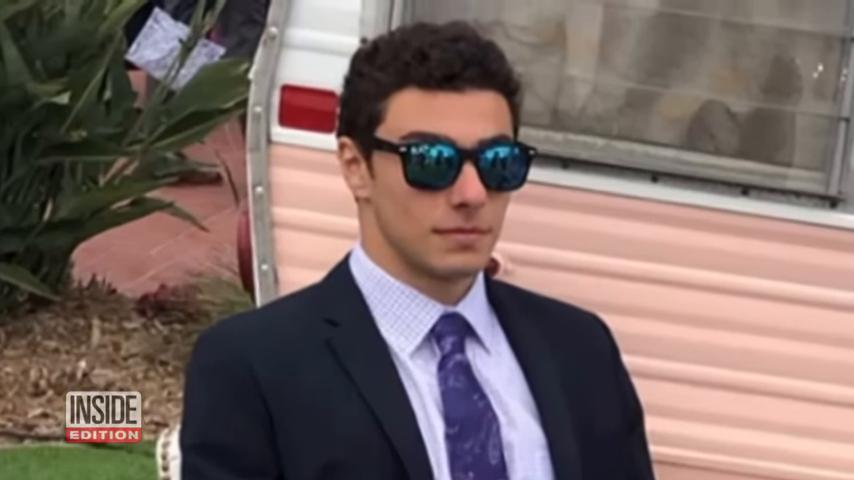

{'image': '/content/imgs/frames/Yzt7KnWfwgs/50.jpeg', 'qa': [{'question': "Given this image and the video transcript, generate a prompt for Stable Diffusion. The response should only include the prompt. Here is the transcript: 's police care something say assassin employee family last united one monopoly valedictorian murder country", 'answer': " The image shows a young man standing on a grassy hillside, smiling at the camera. He is shirtless and wearing a black backpack. The hillside is covered in lush green vegetation, including ferns and other plants. The man's gaze is directed towards the camera, creating a sense of connection with the viewer. The image is taken from a slightly elevated angle, providing a view of the man and the surrounding landscape."}]}
Question: Given this image and the video transcript, generate a prompt for Stable Diffusion. The response should only include the prompt. Here is the transcript: 's police care something say assassin employee family last united on

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


Moondream: A man wearing sunglasses and a suit stands in front of a pink trailer.


In [ ]:
# example inference
# (only works with embeddings generated with inference embeddings created via vid_to_emb(..., inference_finetune="inference"))


from IPython.display import display

sample = train_data[0]
display(Image.open(sample['image']))
print(sample)


for qa in sample['qa']:
    print('Question:', qa['question'])
    print('Ground Truth:', qa['answer'])
    print('Moondream:', moondream.answer_question(
        moondream.encode_image(Image.open(sample['image'])),
        qa['question'],
        tokenizer=tokenizer,
    ))


### Training

Let's start setting up hyperparameters for finetuning.

In [ ]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 10

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory.
BATCH_SIZE = 8

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 2

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 1e-5

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = False


This next block will start the training process.

In [ ]:
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    images = [moondream.vision_encoder.preprocess(Image.open(image)) for image in images]

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        for qa in sample['qa']:
            q_t = tokenizer(
                f"\n\nQuestion: {qa['question']}\n\nAnswer:",
                add_special_tokens=False
            ).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))

            a_t = tokenizer(
                f" {qa['answer']}{ANSWER_EOS}",
                add_special_tokens=False
            ).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images,
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder(images)
        #print("img_embds:", img_embs.shape)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)
    #print("inputs_embds:", inputs_embeds.shape)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

dataloaders = {
    "train": DataLoader(
        train_data, #datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    )
}

moondream.text_model.train()
moondream.config.use_cache = False
moondream.text_model.transformer.gradient_checkpointing_enable()


total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
optimizer = Adam8bit(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

if USE_WANDB:
    import wandb
    wandb.init(
        project="moondream-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if USE_WANDB:
            wandb.log({
                "loss/train": loss.item(),
                "lr": optimizer.param_groups[0]['lr']
            })

if USE_WANDB:
    wandb.finish()

Epoch 10/10: 100%|██████████| 71/71 [07:02<00:00,  5.95s/it]


In [ ]:
# save model
torch.save(moondream.state_dict(), "/content/drive/MyDrive/moondream_ft_moon_mean_eps10_bs8_1frame")

In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/moondream_ft_moon_mean_eps10_bs8_1frame")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Testing

Now that training has completed, let's inspect a sample.

In [ ]:
# load model
moondream.load_state_dict(torch.load("/content/drive/My Drive/moondream_ft_moon_mean_eps10_bs8", weights_only=True))

<All keys matched successfully>

In [ ]:
moondream.eval()
moondream.answer_question(
        moondream.encode_image(Image.open("/content/imgs/frames/-6x8t4ZDUD0/0.jpeg")),
        "Describe this image.",
        tokenizer=tokenizer
    )

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
  warnings.warn(



RuntimeError: Sizes of tensors must match except in dimension 3. Expected size 744 but got size 1 for tensor number 1 in the list.

In [1]:
'''
# Not used
# code to calculate accuracy if ground truth wouldn't be texts, but deterministic answers (e.g. a clear 0 or 1)
moondream.eval()

correct = 0

for i, sample in enumerate(test_data):
    md_answer = moondream.answer_question(
        moondream.encode_image(Image.open(sample['image'].filename)),
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
        num_beams=4,
        no_repeat_ngram_size=5,
        early_stopping=True
    )

    if md_answer == sample['qa'][0]['answer']:
        correct += 1


    if i < 3:
        display(Image.open(sample['image'].filename))
        print('Question:', sample['qa'][0]['question'])
        print('Ground Truth:', sample['qa'][0]['answer'])
        print('Moondream:', md_answer)
    else:
        break

print(f"\n\nAccuracy: {correct / len(test_data) * 100:.2f}%")
'''

NameError: name 'moondream' is not defined

---